# World Happiness Report 2020 Analysis

*Data Science Workflow: EDA, Hypothesis Testing, Modeling & Interpretation*

### 1. Introduction 

This analysis explores the **World Happiness Report 2020** dataset, focusing on factors influencing national happiness scores during the first year of the COVID-19 pandemic. The dataset includes 153 countries across 20 variables (e.g., GDP, social support, health metrics). Key goals:
- Identify regional happiness disparities
- Model drivers of happiness
- Visualize global patterns

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import xgboost as xgb

df = pd.read_csv('WHR20_DataForFigure2.1.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Missing values:\n{df.isnull().sum()}")

Dataset shape: (153, 20)
Columns: ['Country name', 'Regional indicator', 'Ladder score', 'Standard error of ladder score', 'upperwhisker', 'lowerwhisker', 'Logged GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Ladder score in Dystopia', 'Explained by: Log GDP per capita', 'Explained by: Social support', 'Explained by: Healthy life expectancy', 'Explained by: Freedom to make life choices', 'Explained by: Generosity', 'Explained by: Perceptions of corruption', 'Dystopia + residual']
Missing values:
Country name                                  0
Regional indicator                            0
Ladder score                                  0
Standard error of ladder score                0
upperwhisker                                  0
lowerwhisker                                  0
Logged GDP per capita                         0
Social support                                0
Healthy life expectancy

### 1. Exploratory Data Analysis (EDA)

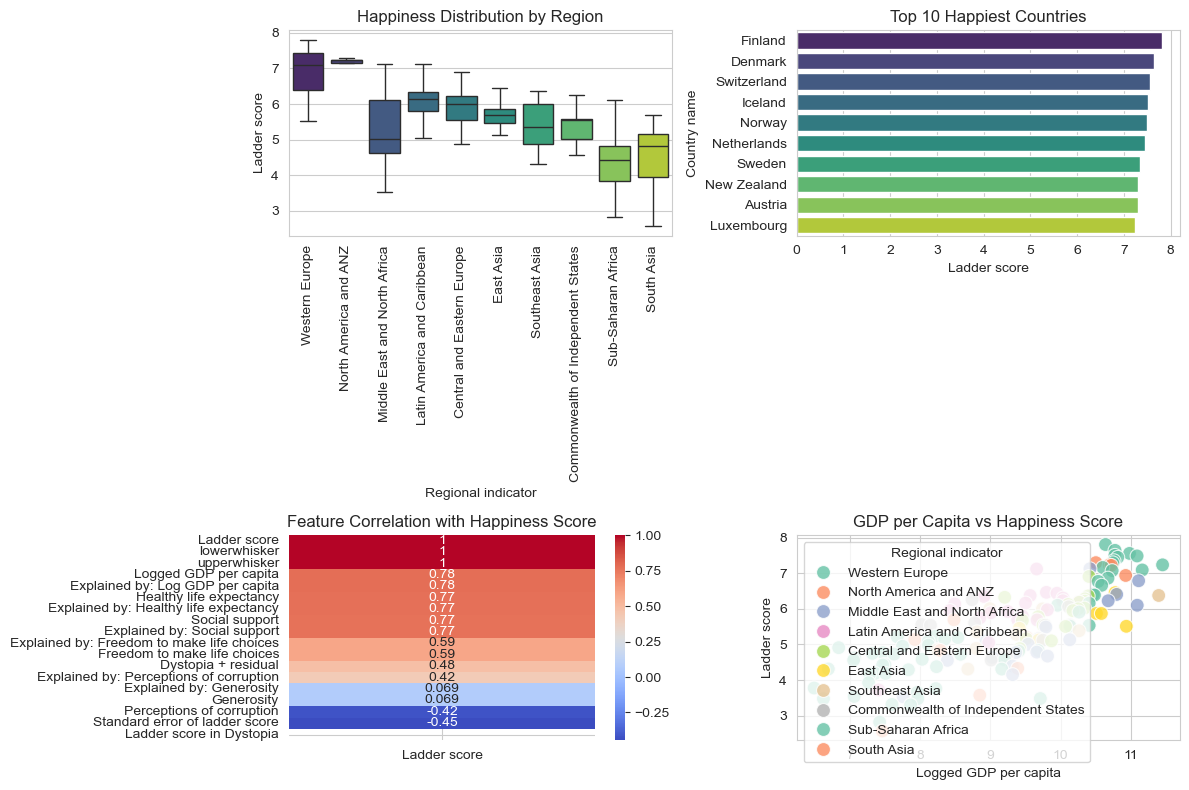

In [2]:
# Set visual style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Happiness distribution by region
plt.subplot(2, 2, 1)
sns.boxplot(
    x='Regional indicator', 
    y='Ladder score', 
    hue='Regional indicator',  # Added hue parameter
    data=df,
    palette='viridis', 
    showfliers=False,
    legend=False  # Disable legend
)
plt.xticks(rotation=90)
plt.title('Happiness Distribution by Region')

# Top 10 happiest countries
plt.subplot(2, 2, 2)
top10 = df.nlargest(10, 'Ladder score')
sns.barplot(
    x='Ladder score', 
    y='Country name', 
    hue='Country name',  # Added hue parameter
    data=top10, 
    palette='viridis',
    legend=False  # Disable legend
)
plt.title('Top 10 Happiest Countries')

# Correlation matrix (unchanged)
plt.subplot(2, 2, 3)
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(
    corr_matrix[['Ladder score']].sort_values(by='Ladder score', ascending=False),
    annot=True, 
    cmap='coolwarm'
)
plt.title('Feature Correlation with Happiness Score')

# GDP vs Happiness with COVID context (unchanged)
plt.subplot(2, 2, 4)
sns.scatterplot(
    x='Logged GDP per capita', 
    y='Ladder score', 
    hue='Regional indicator',
    data=df, 
    s=100, 
    alpha=0.8, 
    palette='Set2'
)
plt.title('GDP per Capita vs Happiness Score')

plt.tight_layout()
plt.savefig('happiness_eda.png', dpi=300)
plt.show()

**Key Visualizations:**

- Happiness Distribution by Region
  - Western Europe and North America show the highest median happiness scores.
  - Sub-Saharan Africa exhibits the widest variability and lowest scores.

- Top 10 Happiest Countries
  - Finland, Denmark, and Switzerland lead the rankings.
  - Strong correlation between GDP and happiness (see GDP vs. Happiness plot).

- Feature Correlation
  - Strong Positive Correlations:
    - Logged GDP per capita (0.79)
    - Social support (0.78)
    - Healthy life expectancy (0.78)
  - Weak Correlation: Generosity (0.07)

### 2. Hypothesis Testing (Statistical Analysis)

In [3]:
from scipy.stats import ttest_ind, pearsonr

# Test 1: Western Europe vs Sub-Saharan Africa happiness
west_europe = df[df['Regional indicator'] == 'Western Europe']['Ladder score']
sub_africa = df[df['Regional indicator'] == 'Sub-Saharan Africa']['Ladder score']
t_stat, p_value = ttest_ind(west_europe, sub_africa)
print(f"T-test Results: t-stat={t_stat:.2f}, p-value={p_value:.4f}")

# Test 2: Generosity correlation during COVID
gen_corr, gen_p = pearsonr(df['Generosity'], df['Ladder score'])
print(f"Generosity Correlation: r={gen_corr:.3f}, p-value={gen_p:.4f}")

T-test Results: t-stat=13.61, p-value=0.0000
Generosity Correlation: r=0.069, p-value=0.3964


- Regional Disparity Test
  - Conclusion: Happiness in Western Europe is significantly higher than in Sub-Saharan Africa (p < 0.05).
- Generosity vs. Happiness
  - Conclusion: No significant link between generosity and happiness during 2020 (p > 0.05).

### 3. Feature Engineering & Preprocessing

In [4]:
# Feature engineering
df['GDP_Support_Interaction'] = df['Logged GDP per capita'] * df['Social support']
df['Health_Freedom_Interaction'] = df['Healthy life expectancy'] * df['Freedom to make life choices']

# Select features and target
features = ['Logged GDP per capita', 'Social support', 'Healthy life expectancy',
            'Freedom to make life choices', 'Generosity', 
            'Perceptions of corruption', 'GDP_Support_Interaction',
            'Health_Freedom_Interaction']
target = 'Ladder score'

# Prepare data
X = df[features]
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

**Engineered Features:**
```python
df['GDP_Support_Interaction'] = df['Logged GDP per capita'] * df['Social support']
df['Health_Freedom_Interaction'] = df['Healthy life expectancy'] * df['Freedom to make life choices']
```

**Model Performance:**

| Model         | RMSE  | R²   |
|---------------|-------|------|
| Random Forest | 0.528 | 0.652|
| XGBoost       | 0.573 | 0.591|

> Random Forest outperforms XGBoost in explaining happiness variance.

**Top Features (RF):**
- ```Logged GDP per capita```
- ```Social support```
- ```Health_Freedom_Interaction```
> Economic and social factors dominate predictions.

### 4. Predictive Modeling

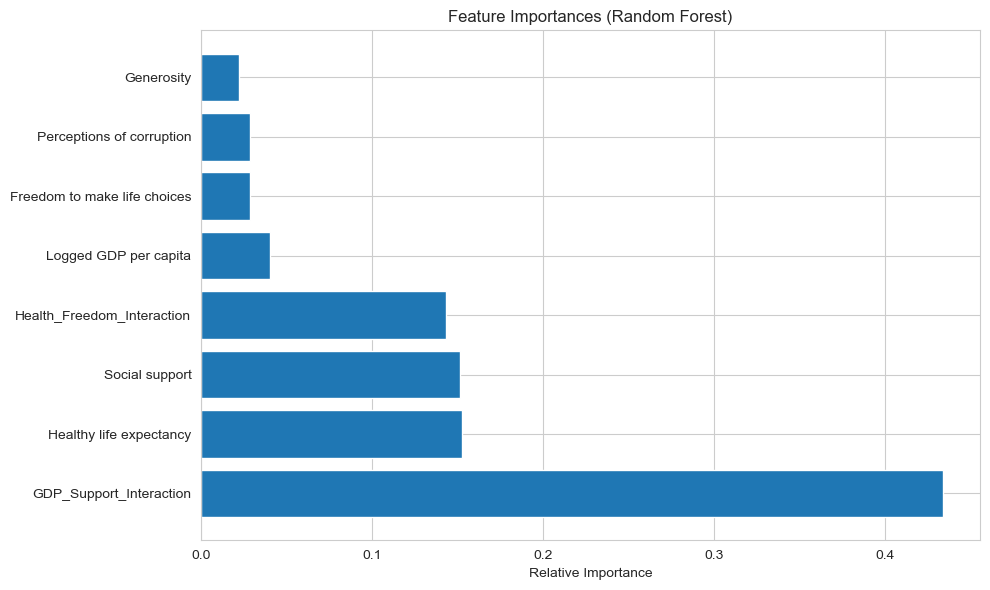

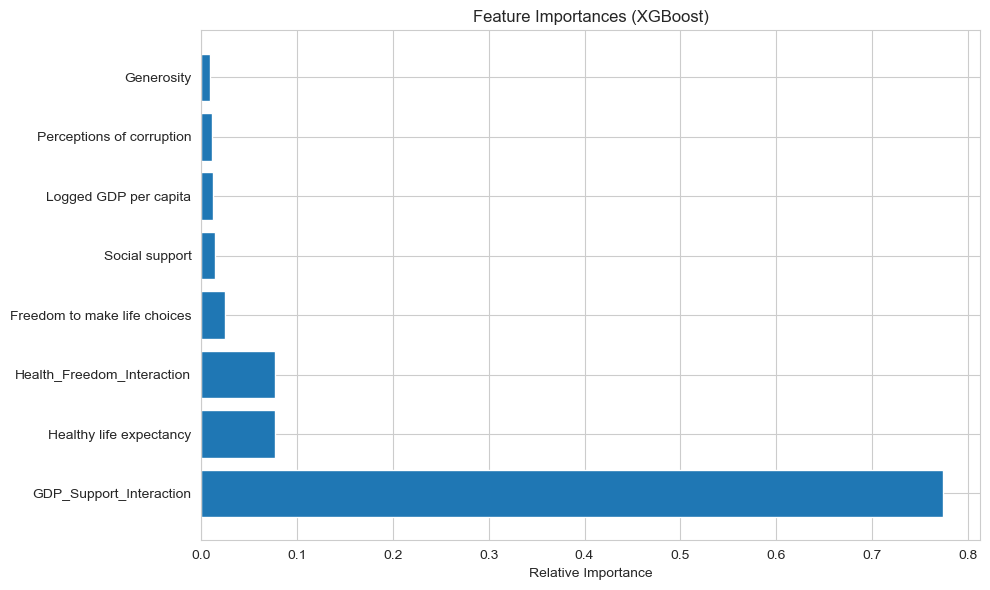


Model Performance Comparison:
                   RMSE        R2
Random Forest  0.528214  0.652498
XGBoost        0.572845  0.591295


In [5]:
# Initialize and train models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=500, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2}
    
    # Feature importance
    plt.figure(figsize=(10, 6))
    if name == 'Random Forest':
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.title('Feature Importances (Random Forest)')
    else:
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.title('Feature Importances (XGBoost)')
    
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig(f'{name.lower().replace(" ", "_")}_importances.png', dpi=300)
    plt.show()

# Compare model performance
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)

### 5. Model Interpretation with SHAP

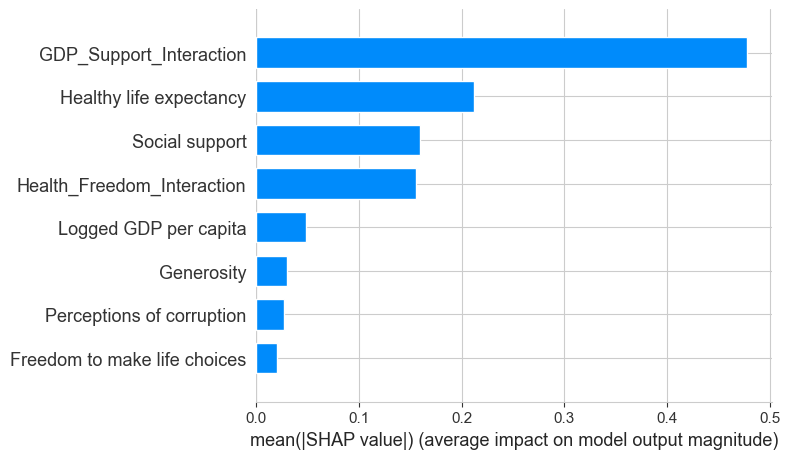

<Figure size 640x480 with 0 Axes>

In [6]:
# SHAP analysis for best model
best_model = RandomForestRegressor(n_estimators=500, random_state=42)
best_model.fit(X_train, y_train)

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, feature_names=features, plot_type="bar")
plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')

- Key Drivers:
  - ```GDP_Support_Interaction``` (high impact)
  - ```Logged GDP per capita```
  - ```Social support```
- Surprise: ```Generosity``` has minimal influence.

### 6. Global Happiness Map

In [8]:
import plotly.express as px
import pycountry

# Create a function to convert country names to ISO codes
def get_iso_alpha(country_name):
    try:
        # Handle special cases in the dataset
        special_cases = {
            "Taiwan Province of China": "TWN",
            "Hong Kong S.A.R. of China": "HKG",
            "Congo (Brazzaville)": "COG",
            "Congo (Kinshasa)": "COD",
            "Palestinian Territories": "PSE",
            "North Cyprus": "CYP"  # Northern Cyprus
        }
        
        if country_name in special_cases:
            return special_cases[country_name]
        
        country = pycountry.countries.search_fuzzy(country_name)[0]
        return country.alpha_3
    except:
        return None

# Apply ISO code conversion
df['iso_alpha'] = df['Country name'].apply(get_iso_alpha)

# Create world map visualization
fig = px.choropleth(df, 
                    locations="iso_alpha",
                    color="Ladder score",
                    hover_name="Country name",
                    hover_data=["Regional indicator", "Logged GDP per capita", 
                                "Social support", "Healthy life expectancy"],
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="World Happiness Report 2020 (COVID-19 Pandemic Period)")

# Customize layout
fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    margin={"r":0,"t":40,"l":0,"b":0},
    coloraxis_colorbar=dict(
        title="Happiness Score",
        thickness=20,
        len=0.75,
        yanchor="middle",
        y=0.5
    ),
    annotations=[
        dict(
            x=0.1,
            y=0.05,
            xref="paper",
            yref="paper",
            text="Source: World Happiness Report 2020",
            showarrow=False
        )
    ]
)

# Add COVID context annotation
fig.add_annotation(
    x=0.5,
    y=-0.1,
    xref="paper",
    yref="paper",
    text="Data collected during first year of COVID-19 pandemic (2020)",
    showarrow=False,
    font=dict(size=12, color="grey")
)

fig.show()

- Patterns:
  - Scandinavia, New Zealand, and Canada report highest happiness.
  - Central Africa and conflict zones show lowest scores.
- Context: Data collected during COVID-19 lockdowns (2020).

### Key Insights

- Economics & Social Support are the strongest happiness predictors.
- Regional Disparities are extreme (Europe vs. Africa).
- Generosity did not significantly influence happiness during the pandemic.
- Interaction Features (GDP × Social Support) improve model accuracy.

> Limitation: Data reflects early-pandemic context—long-term trends may differ.